# Atividade Widget Jupyter
Implementar um widget no Jupyter para controlar um gráfico interativamente.

In [1]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import bs4, json, os, requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Obtém os Senadores Eleitos em 2018
Faz uma requisição ao site [Eleições 2018](https://www.eleicoes2018.com/candidatos-senador/) e obtém os dados dos senadores eleitos. Após toda a leitura grava os dados em um arquivo JSON para que próximas requisições não sejam necessárias.

In [2]:
def senadores_eleitos():
    
    if os.path.exists('senadores.json'):
        with open('senadores.json', 'r') as f:
            return json.load(f)

    res = requests.get("https://www.eleicoes2018.com/candidatos-senador/")
    html = bs4.BeautifulSoup(res.text, features='lxml')
    candidatos_html = html.select('.card-candidate-results')
    
    candidatos = []
    for tag_a in candidatos_html:
        # verifica se é um senador eleito.
        if tag_a.select_one('.elect-state') == None:
            continue

        c = {}
        c['nome'], _, c['numero'] = tag_a.select_one('.candidate-name').getText().rpartition(' ')
        c['partido'], _ , c['estado'] = tag_a.select_one('.candidate-party').getText().partition(' - ')
        c['votos_porc'] = float(tag_a.select_one('.percentage').getText().replace('%', ''))
        c['votos'] = int(tag_a.select_one('.number-votes').getText().rpartition(' ')[0].replace(' ', ''))
        candidatos.append(c)

    with open('senadores.json', 'w') as f:
        f.write(json.dumps(candidatos))

    return candidatos


In [3]:
senadores = senadores_eleitos()

partidos = set([ s['partido'] for s in senadores])
estados = set([ s['estado'] for s in senadores])

### Plotar Gráfico

Os senadores a serem exibidos no gráfico serão selecionados a partir da função <code>condicao(senador)</code>. A função deve retornar <code>True</code> se o parâmetro <code>senador</code> deve ser considerado no gráfico.

In [4]:
def plotar_grafico(condicao, legendas=estados, key_legenda='estado'):
    #plt.rcParams['figure.figsize'] = [15, 8]
    _ , ax = plt.subplots()    
    legenda = {'plots': [], 'leg': []}
    
    # Obtém os senadores de acordo com a condição passada por parâmetro.
    senadores_selecionados = [s for s in senadores if condicao(s)]
    
    # Separa os candidatos para criar uma legenda para o gráfico.
    for label in legendas:
        y = np.array([s['nome'] +' - '+ s['estado'] for s in senadores_selecionados if s[key_legenda] == label])
        x = np.array([s['votos_porc'] for s in senadores_selecionados if s[key_legenda] == label])

        if len(x) == 0: continue
        x, y = zip(*sorted(zip(x, y)))

        p1 = ax.barh(y, x)
        legenda['plots'].append(p1[0])
        legenda['leg'].append(label)

    ax.grid()
    ax.set(
        xlabel='Porcentagem de votos (%)', 
        ylabel='Senador',
        title='Senadores Eleitos'
    )
    
    plt.legend(tuple(legenda['plots']), tuple(legenda['leg']))
    plt.show()
    


### Criação dos Widgets

In [5]:
drop_partido = widgets.Dropdown(
    options=sorted(partidos),
    value=list(partidos)[0],
    description='Partido:',
    disabled=False,
)

drop_estado = widgets.Dropdown(
    options=sorted(estados),
    value=list(estados)[0],
    description='Estado:',
    disabled=False,
)

slider_porcent = widgets.FloatRangeSlider(
    value=[32.5, 60],
    min=0,
    max=100,
    step=2.5,
    description='Votos (%):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

### Tratando eventos dos widgets

In [6]:
def widget_modificado(e):
    if e['name'] == 'value':
        clear_output(wait=True)
        display(e['owner'])
        
        if e['owner'] == drop_estado:
            plotar_grafico(
                lambda s: True if s['estado'] == e['new'] else False, 
                partidos, 
                'partido'
            )
        elif e['owner'] == drop_partido:
            plotar_grafico(
                lambda s: True if s['partido'] == e['new'] else False, 
                estados, 
                'estado'
            )
        else:
            min, max = e['new']
            plotar_grafico(
                lambda s: True if s['votos_porc'] > min and s['votos_porc'] < max else False, 
                partidos, 
                'partido'
            )

            
drop_partido.observe(widget_modificado)
drop_estado.observe(widget_modificado)
slider_porcent.observe(widget_modificado)

### Interação com os gráficos

Dropdown(description='Partido:', options=('DEM', 'MDB', 'PDT', 'PHS', 'PODE', 'PP', 'PPS', 'PR', 'PRB', 'PROS'…

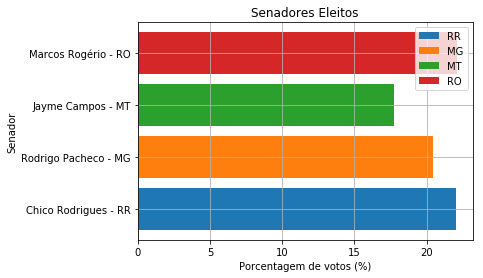

In [7]:
display(drop_partido)

Dropdown(description='Estado:', index=10, options=('AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA',…

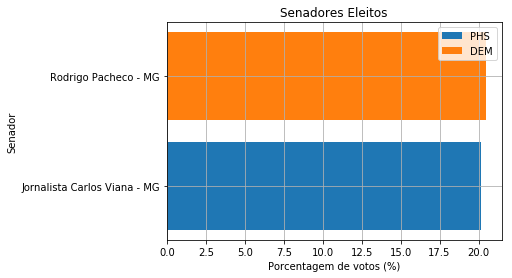

In [8]:
 display(drop_estado)

FloatRangeSlider(value=(30.0, 60.0), continuous_update=False, description='Votos (%):', readout_format='.1f', …

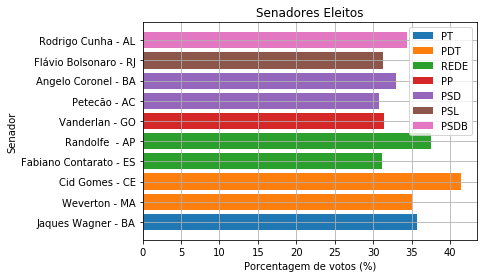

In [9]:
display(slider_porcent)